In [118]:
import numpy as np
import pandas as pd
import requests
from typing import Union
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from functools import reduce

from finlib import calculate_cagr, FundMeta
from myfunds import funds as myfunds

In [119]:
def get_mf_data(url, prefix: str) -> pd.DataFrame:
    response = requests.get(url).json()['data']
    df = pd.DataFrame(response)
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

    # Set 'date' column as the index
    df.set_index('date', inplace=True)
    df = df.sort_index(ascending=True)
    # Convert 'nav' column to numeric (decimal)
    df['nav'] = pd.to_numeric(df['nav'])
    
    # df['returns'] = df['nav'].pct_change()
    df['returns'] = df['nav']/df['nav'].shift(1) - 1
    df['log_return'] = np.log(df['nav'] / df['nav'].shift(1))
    df = df.drop(df.index[0])

    # Normalize values to be relative to the first value
    # df['nav_normalized'] = (df['nav'] / df['nav'].iloc[0]) * 100

    df.columns = [prefix + col for col in df.columns]

    return df

def enrich_with_normalized_navs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Enrich the DataFrame with normalized NAV values.
    """

    columns_of_interest = [column_name for column_name in df.columns.tolist() if column_name.endswith('_nav')]
    for column_name in columns_of_interest:
        df[column_name + '_normalized_nav'] = (df[column_name] / df[column_name].iloc[0]) * 100

    return df

def compute_return(df: pd.DataFrame, start_date : Union[str, pd.Timestamp], end_date : Union[str, pd.Timestamp]) -> float:
    """
    Compute the return of a mutual fund between two dates.
    """
    # Retrieve the 'nav' values for the start and end dates
    start_nav = df.loc[start_date, 'nav']
    end_nav = df.loc[end_date, 'nav']
    
    # Compute the return
    return_value = (end_nav - start_nav) / start_nav
    
    return return_value

def merge_dataframes_on_index(dfs):
    """
    Merge multiple DataFrames on their index.

    Parameters:
    dfs (list of pd.DataFrame): List of DataFrames to merge.
    how (str): Type of merge to be performed. Default is 'inner'.

    Returns:
    pd.DataFrame: Merged DataFrame.
    """
    return reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), dfs)

def calculate_last_n_years_cagr(returns: pd.Series, years: int) -> float:
    """
    Calculate the Compound Annual Growth Rate (CAGR) of a Series of returns over the last n years.
    """
    # Calculate the total return over the period
    total_return = returns.prod()

    # Calculate the number of years
    n_years = len(returns) / 252

    # Calculate the CAGR
    cagr = total_return ** (1 / n_years) - 1

    return cagr

def plot_returns(df: pd.DataFrame, title: str):
    df['returns'].plot(figsize=(12, 8), title=title)
    plt.show()


In [120]:
fund_variable_prefix = 'mf_'

for fundmeta in myfunds:
    globals()[fund_variable_prefix + fundmeta.moniker] = get_mf_data(fundmeta.url, fundmeta.moniker + '_')


In [121]:
fund_vars = [value for key,value in globals().items() if key.startswith(fund_variable_prefix)]

master_data = enrich_with_normalized_navs(merge_dataframes_on_index(fund_vars))

In [122]:
master_data.head()

,icicipru_eq_and_debt_nav,icicipru_eq_and_debt_returns,icicipru_eq_and_debt_log_return,ppfas_fcf_nav,ppfas_fcf_returns,ppfas_fcf_log_return,hdfc_mco_nav,hdfc_mco_returns,hdfc_mco_log_return,icicipru_eq_and_debt_nav_normalized_nav,ppfas_fcf_nav_normalized_nav,hdfc_mco_nav_normalized_nav
date,,,,,,,,,,,,
2013-05-29,56.88,0.000528,0.000528,10.0080,0.000880,0.000880,18.097,0.000498,0.000497,100.000000,100.000000,100.000000
2013-05-30,56.93,0.000879,0.000879,10.0327,0.002468,0.002465,18.071,-0.001437,-0.001438,100.087904,100.246803,99.856330
2013-05-31,56.25,-0.011944,-0.012016,10.0154,-0.001724,-0.001726,17.963,-0.005976,-0.005994,98.892405,100.073941,99.259546
2013-06-03,56.15,-0.001778,-0.001779,10.0572,0.004174,0.004165,18.057,0.005233,0.005219,98.716596,100.491607,99.778969
2013-06-04,56.10,-0.000890,-0.000891,10.0339,-0.002317,-0.002319,18.042,-0.000831,-0.000831,98.628692,100.258793,99.696082


Now that we have the data for individual mutual funds in our hands, we can start to analyze the data. In the next step, we'll try to figure out the summary statistics for the funds like the average return, standard deviation, and the Sharpe ratio.

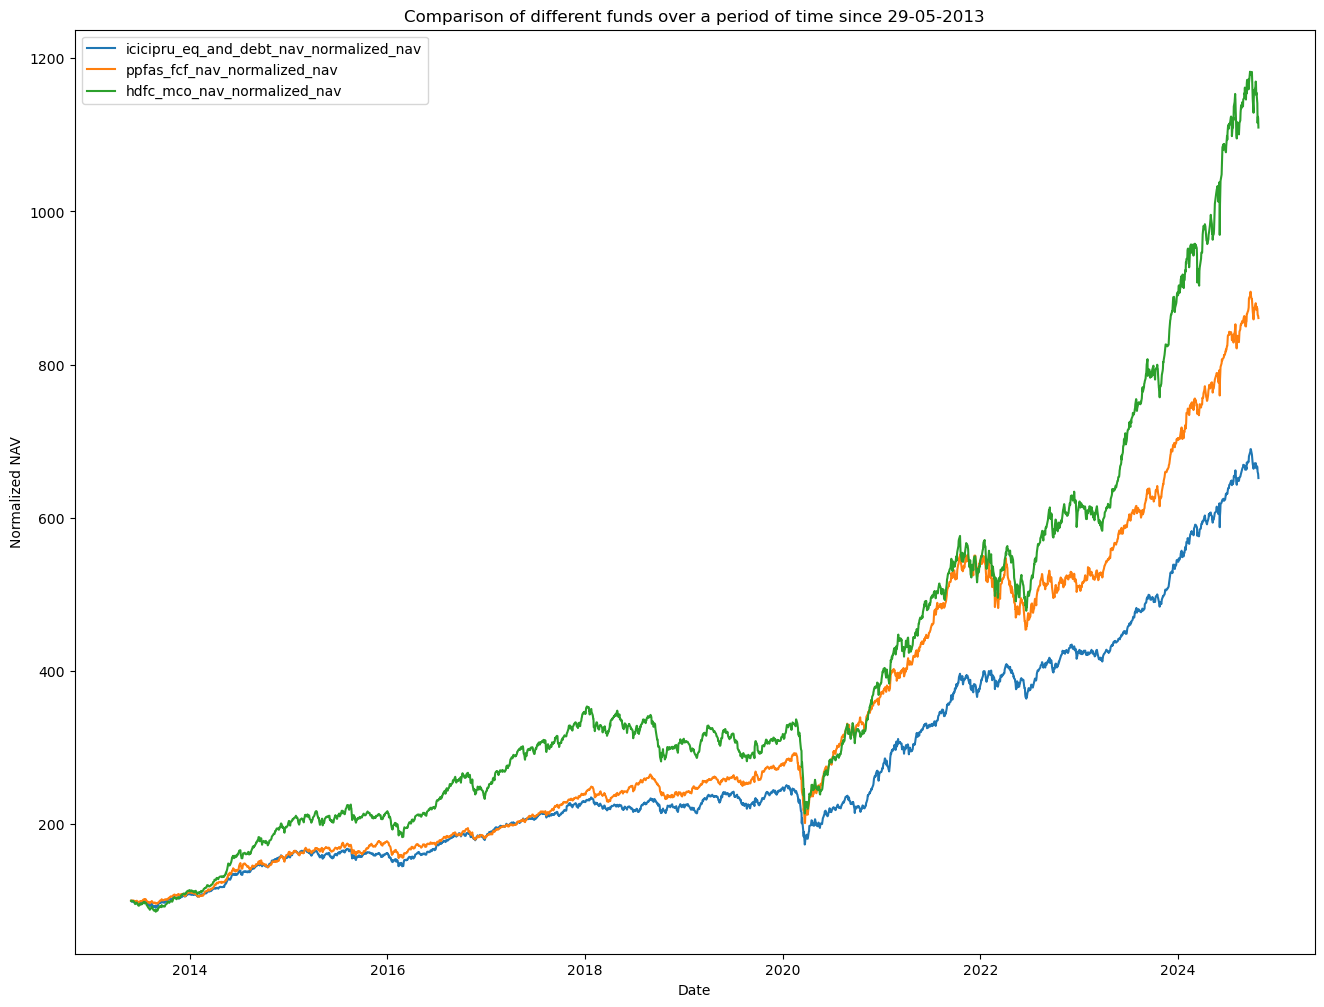

In [123]:
plt.figure(figsize=(16, 12))

chart_data = master_data[master_data.index > '2012-10-14']

for column in [column_name for column_name in chart_data.columns.tolist() if column_name.endswith('normalized_nav')]:
    plt.plot(chart_data.index, chart_data[column], label=column)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Normalized NAV')
plt.title('Comparison of different funds over a period of time since {0}'.format(chart_data.iloc[0].name.strftime('%d-%m-%Y')))
plt.legend()
plt.grid(False)

# plt.axvspan('2022-01-15', '2023-01-25', color='yellow', alpha=0.3, label='Consolidation')
# plt.axvspan('2023-01-26', '2024-02-20', color='red', alpha=0.3, label='Correction')
# plt.axvspan('2024-02-21', '2024-09-28', color='green', alpha=0.3, label='Bull Run')

# Display the plot
plt.show()

Let us try to calculate the average return, standard deviation, and Sharpe ratio for the funds.

In [124]:
return_matrix = pd.DataFrame(columns=['Moniker', 'Fund', 'Expected Return', 'Volatility', 'Sharpe Ratio'])
risk_free_return = 0.075
margin_of_safety = 0.02

for fundmeta in myfunds:
    print(fundmeta.fund_name)
    trading_days_per_year = 252  # Typical number of trading days in a year

    col = fundmeta.moniker + '_nav_normalized_nav'
    col_log_return = fundmeta.moniker + '_log_return'
    years = (master_data[col].index[-1] - master_data[col].index[0]).days / 365

    cagr_returns = calculate_cagr(master_data[col].iloc[0], master_data[col].iloc[-1], years)
    absolute_returns = (master_data[col].iloc[-1] / master_data[col].iloc[0]) - 1
    
    daily_volatility = master_data[col_log_return].std()

    annual_volatility = daily_volatility * np.sqrt(trading_days_per_year)

    sharpe_ratio = (cagr_returns - risk_free_return) / annual_volatility

    # Define the new row as a dictionary
    new_row = {'Moniker': fundmeta.moniker, 'Fund': fundmeta.fund_name , 'Expected Return': cagr_returns - margin_of_safety, 'Volatility': annual_volatility, 'Sharpe Ratio': sharpe_ratio}

    # Convert the new row to a DataFrame
    new_row_df = pd.DataFrame([new_row])

    # Add the new row using pd.concat
    return_matrix = pd.concat([return_matrix, new_row_df])
    
    print('\tCAGR return since begining of analysis: {0:.2f}%'.format(cagr_returns * 100))
    print('\tAbsolute return since begining of analysis: {0:.2f}%'.format(absolute_returns * 100))
    print('\tAnnual Volatility: {0:.2f}'.format(annual_volatility * 100))
    print('\tSharpe Ratio: {0:.2f}'.format(sharpe_ratio))
    print('\n')

ICICI Pru Equity & Debt Fund
	CAGR return since begining of analysis: 17.85%
	Absolute return since begining of analysis: 551.93%
	Annual Volatility: 12.32
	Sharpe Ratio: 0.84


PPFAS Flexi Cap Fund
	CAGR return since begining of analysis: 20.75%
	Absolute return since begining of analysis: 760.84%
	Annual Volatility: 12.31
	Sharpe Ratio: 1.08


HDFC Mid-Cap Opportunities Fund
	CAGR return since begining of analysis: 23.47%
	Absolute return since begining of analysis: 1009.62%
	Annual Volatility: 15.99
	Sharpe Ratio: 1.00




/var/folders/tg/rc8ffqvd6_n5j4txby9bnl4h0000gn/T/ipykernel_79642/3372207251.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return_matrix = pd.concat([return_matrix, new_row_df])


In [125]:
return_matrix

,Moniker,Fund,Expected Return,Volatility,Sharpe Ratio
0,icicipru_eq_and_debt,ICICI Pru Equity & Debt Fund,0.158470,0.123158,0.840139
0,ppfas_fcf,PPFAS Flexi Cap Fund,0.187515,0.123102,1.076468
0,hdfc_mco,HDFC Mid-Cap Opportunities Fund,0.214667,0.159938,0.998310


Compute correlation matrix for the funds

In [126]:
correlation_matrix = master_data[[fundmeta.moniker + '_returns' for fundmeta in myfunds]].corr().to_numpy()
correlation_matrix

array([[1.        , 0.74559086, 0.86089321],
       [0.74559086, 1.        , 0.76649619],
       [0.86089321, 0.76649619, 1.        ]])

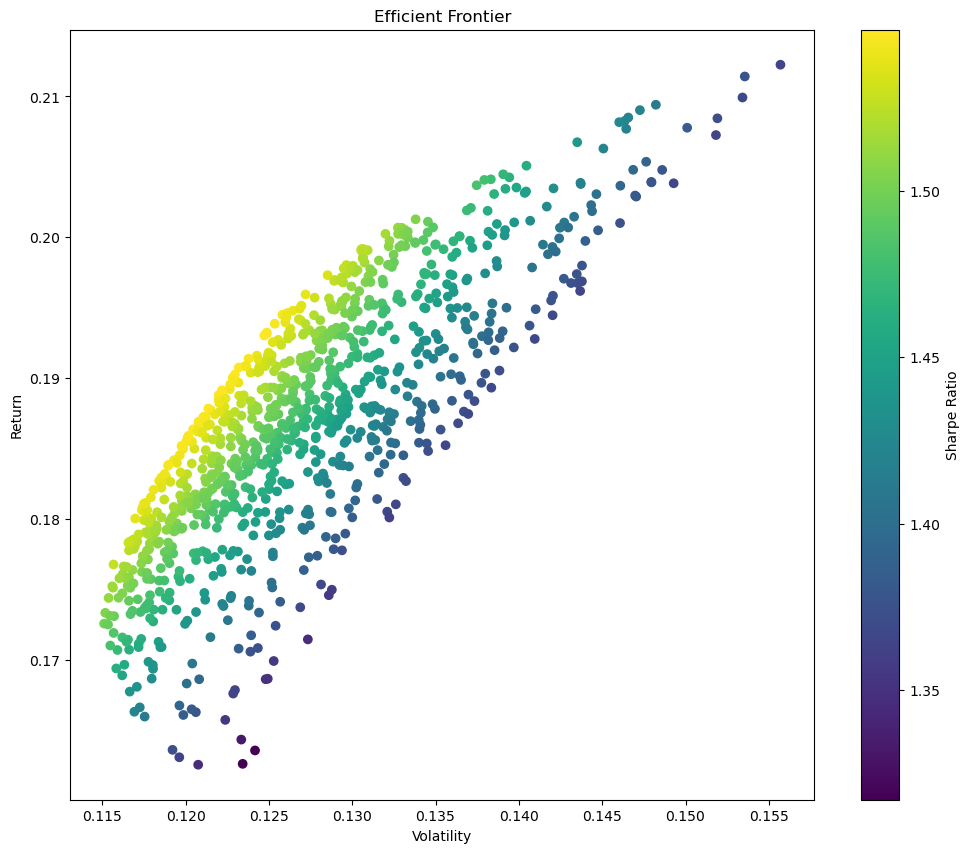

In [127]:
# Step 1: Define the expected returns and volatilities for each security
securities = return_matrix['Fund'].to_numpy()
expected_returns = return_matrix['Expected Return'].to_numpy()
volatilities = return_matrix['Volatility'].to_numpy()

# Step 2: Calculate the covariance matrix
cov_matrix = np.outer(volatilities, volatilities) * correlation_matrix

# Step 3: Generate random portfolios
num_portfolios = 1000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(securities))
    weights /= np.sum(weights)
    
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = results[0,i] / results[1,i]  # Sharpe Ratio

# Step 4: Plot the efficient frontier
plt.figure(figsize=(12, 10))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()

Optimize the portfolio

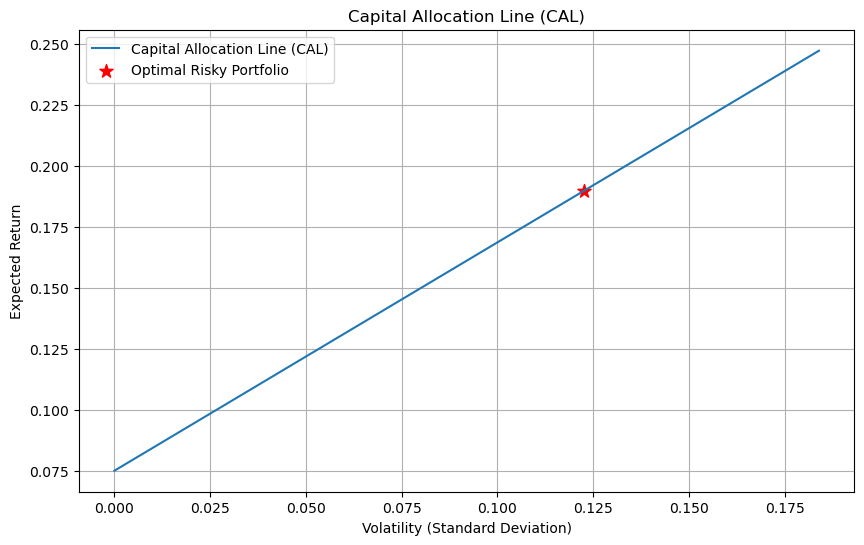

In [128]:
# Define the acceptable level of volatility
acceptable_volatility = 0.15
risk_free_rate = 0.075

# Define the number of securities
num_securities = len(securities)

# Define the objective function to minimize (negative Sharpe ratio)
def objective(weights):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio

# Define the constraint for acceptable volatility
def volatility_constraint(weights):
    return acceptable_volatility - np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Define the constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
               {'type': 'ineq', 'fun': volatility_constraint})
bounds = tuple((0, 1) for _ in range(num_securities))

# Initial guess for the weights
initial_guess = num_securities * [1. / num_securities]

# Perform the optimization
result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal weights
optimal_weights = result.x

# Calculate the expected return and volatility of the optimal risky portfolio
optimal_portfolio_return = np.dot(optimal_weights, expected_returns)
optimal_portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

# Generate the Capital Allocation Line (CAL)
cal_returns = []
cal_volatilities = []

for weight in np.linspace(0, 1.5, 100):
    cal_return = risk_free_rate + weight * (optimal_portfolio_return - risk_free_rate)
    cal_volatility = weight * optimal_portfolio_volatility
    cal_returns.append(cal_return)
    cal_volatilities.append(cal_volatility)

# Plot the CAL
plt.figure(figsize=(10, 6))
plt.plot(cal_volatilities, cal_returns, label='Capital Allocation Line (CAL)')
plt.scatter(optimal_portfolio_volatility, optimal_portfolio_return, color='red', marker='*', s=100, label='Optimal Risky Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Capital Allocation Line (CAL)')
plt.legend()
plt.grid(True)
plt.show()

In [129]:
# Calculate the expected return of the portfolio with the optimal weights
expected_portfolio_return = np.dot(optimal_weights, expected_returns)

print("Optimal Weights:", optimal_weights)

for fund, pct_allocation in zip(securities, optimal_weights):
    print('\t{0}: {1:.2f}%'.format(fund, pct_allocation * 100))
    # print(fund, pct_allocation)
print('\n\nExpected Portfolio Return: {0:.2f}%'.format(expected_portfolio_return * 100))
print('Expected Portfolio Volatility: {0:.2f}%'.format(optimal_portfolio_volatility * 100))

Optimal Weights: [0.07725113 0.75434843 0.16840044]
	ICICI Pru Equity & Debt Fund: 7.73%
	PPFAS Flexi Cap Fund: 75.43%
	HDFC Mid-Cap Opportunities Fund: 16.84%


Expected Portfolio Return: 18.98%
Expected Portfolio Volatility: 12.26%


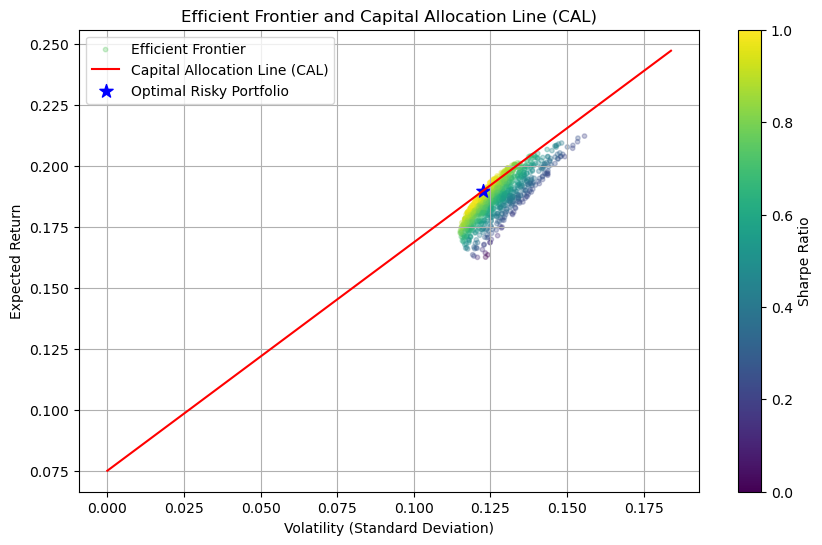

In [130]:
# Plot the CAL and the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.3, label='Efficient Frontier')
plt.plot(cal_volatilities, cal_returns, label='Capital Allocation Line (CAL)', color='red')
plt.scatter(optimal_portfolio_volatility, optimal_portfolio_return, color='blue', marker='*', s=100, label='Optimal Risky Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Capital Allocation Line (CAL)')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()

Now let's see how many times each of the fund we are analyzing has fallen more than 1.5% on an yearly basis

In [131]:
drawdowns = pd.DataFrame()

for fundmeta in myfunds:
    _ = master_data[fundmeta.moniker + '_returns']
    _ = _[_ < -0.015]
    series = _.groupby([_.index.year]).count()
    drawdowns = pd.concat([drawdowns, series], axis=1)

drawdowns.fillna(0, inplace=True)
drawdowns = drawdowns.reindex(sorted(drawdowns.index))
drawdowns = drawdowns.astype(int)
drawdowns.columns = [fund.fund_name for fund in myfunds]
drawdowns

,ICICI Pru Equity & Debt Fund,PPFAS Flexi Cap Fund,HDFC Mid-Cap Opportunities Fund
2013,7,0,8
2014,3,6,10
2015,6,3,14
2016,5,6,12
2017,0,0,5
2018,1,3,15
2019,3,2,6
2020,23,22,24
2021,10,7,18
2022,5,16,23


In [132]:
import math

In [133]:
min(1, 2)

1